In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

plt.rcParams["figure.figsize"] = (11,8)


#### I have decided to use the internet firewall data set from Kaggle
https://www.kaggle.com/tunguz/internet-firewall-data-set

In [2]:
df = pd.read_csv('log2.csv')
y = df.Action.copy()
X = df.drop('Action',axis=1)

# structure of data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [3]:
df.head()

Source Port  Destination Port  NAT Source Port  NAT Destination Port  \
0        57222                53            54587                    53   
1        56258              3389            56258                  3389   
2         6881             50321            43265                 50321   
3        50553              3389            50553                  3389   
4        50002               443            45848                   443   

  Action  Bytes  Bytes Sent  Bytes Received  Packets  Elapsed Time (sec)  \
0  allow    177          94              83        2                  30   
1  allow   4768        1600            3168       19                  17   
2  allow    238         118             120        2                1199   
3  allow   3327        1438            1889       15                  17   
4  allow  25358        6778           18580       31                  16   

   pkts_sent  pkts_received  
0          1              1  
1         10              9  
2          1              1  
3          8              7  
4         13             18

### NOT SNAP analysis

In [4]:
print("Classes visualisation")
df.Action.value_counts().plot(kind='bar')
plt.title('Target (Action)')
plt.grid()
plt.show()

Classes visualisation


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

cls = RandomForestClassifier(max_depth=3, random_state=0)
cls.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, random_state=0)

C:\Users\m84200118\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


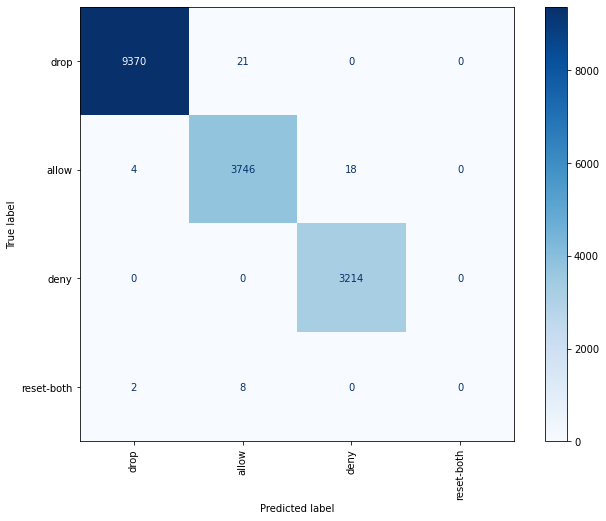

In [6]:
from sklearn.metrics import plot_confusion_matrix

class_names = ['drop', 'allow', 'deny', 'reset-both']
disp = plot_confusion_matrix(cls, X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues, xticks_rotation='vertical')

In [7]:
# plt.title('Feature Importances from scipy')
# plt.barh(range(len(indices)), importances[indices], color='g', align='center')
# plt.yticks(range(len(indices)), [features[i] for i in indices])
# plt.xlabel('Relative Importance from scipy')
# plt.show()

### SHAP analysis

In [8]:
# !pip install shap

In [9]:
import shap

shap.initjs()

# compute SHAP values
explainer = shap.TreeExplainer(cls)
shap_values = explainer.shap_values(X)

importances = cls.feature_importances_
indices = np.argsort(importances)
features = df.columns

In [10]:
shap.summary_plot(shap_values, X.values, plot_type="bar",
    class_names= class_names, feature_names = X.columns)

Here we can see that the order of the most impactful features changed from the scipy graph above. We see that Elapsed time feature matter a lot in determining the target class compared to scipy graph that I generated above.

Also we can see that the class "drop" is hardly determined by Destination Port and Source port as well as Bytes Sent features. Useful to know!

#### further feature analysis

In [65]:
shap.summary_plot(shap_values[1], X.values, feature_names = X.columns)

Here we can see how impactful was each feature including it's value.

In [66]:
print("SHAP Dependence Plot")

shap.dependence_plot(0, shap_values[0], X.values, feature_names=X.columns)

SHAP Dependence Plot


This scatter plot show the effect of a single feature on prediction (each dot is a single prediction). In the graph we can see a dependency between NAT Source Port feature, and Source Port feature.

#### Single example visualisation

In [74]:
i=8
shap.force_plot(explainer.expected_value[0], shap_values[0][i], X.values[i], feature_names = X.columns)

Waterfall plot


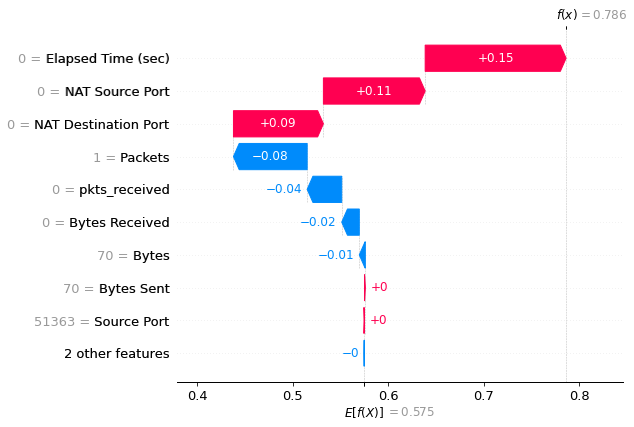

In [75]:
print("Waterfall plot")
row = 8
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row], 
                                              base_values=explainer.expected_value[0], data=X_test.iloc[row],  
                                         feature_names=X_test.columns.tolist()))

Examples from 0 to 7 are not good looking, so let's choose example 8 for visualisa|tion. Model predicts this example with probability 0.79. We can see that NAT Destination Port, NAT Source Port and Elapsed time features contribute to higher value of probability, while Packets = 1, and other minor features decrease the probability. Also the base prediction (base value) of current model is equal to 0.575.